<a href="https://colab.research.google.com/github/snapthat/TF-T5-text-to-text/blob/master/snapthatT5/notebooks/TF-T5-%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../../")

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
from language.config.tfgpuconfig import TFGPUConfig
import tensorflow_datasets as tfds
from transformers import (TFAutoModelWithLMHead, AutoTokenizer, 
    TFTrainer, TFTrainingArguments, TFT5ForConditionalGeneration, T5Config)
import datetime
import os

In [ ]:
os.environ["TF_GPU_THREAD_MODE"]="gpu_private"

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
tfgpu_config = TFGPUConfig()
tfgpu_config.select_gpus([0])  # select gpu
tfgpu_config.set_gpu_memory_growth()
print(f"Total physical gpus: {tfgpu_config.get_physical_gpu_count()}")
print(f"Total Logical gpus: {tfgpu_config.get_logical_gpu_count()}")
print(f"Selected GPU: {tfgpu_config.get_selected_gpus()}")

Total physical gpus: 1
Total Logical gpus: 1
Selected GPU: ['/physical_device:GPU:0']


In [ ]:
log_dir = "/home/ml/workspace/ai/language-modelling/data/experiments/t5/logs"
save_path = "/home/ml/workspace/ai/language-modelling/data/experiments/t5/models"
cache_path_train = "/home/ml/workspace/ai/language-modelling/data/cache/t5.train"
cache_path_test = "/home/ml/workspace/ai/language-modelling/data/cache/t5.test"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")          

In [ ]:
class SnapthatT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss')
#         self.test_loss_tracker= tf.keras.metrics.Mean(name='val_loss')     
        pass
    
    def train_step(self, data):
        x, y  = data
        with tf.GradientTape() as tape:
            outputs = model(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        lr = optimizer.lr
        
        self.loss_tracker.update_state(loss)
        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}

        

In [ ]:
train_dataset, info = tfds.load('squad', split='train', with_info=True)
valid_dataset = tfds.load('squad', split='validation', with_info=False)
print(info)

INFO:absl:No config specified, defaulting to first: squad/plain_text
INFO:absl:Load dataset info from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0
INFO:absl:Reusing dataset squad (/home/ml/tensorflow_datasets/squad/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0
INFO:absl:No config specified, defaulting to first: squad/plain_text
INFO:absl:Load dataset info from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0
INFO:absl:Reusing dataset squad (/home/ml/tensorflow_datasets/squad/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0


tfds.core.DatasetInfo(
    name='squad',
    version=1.0.0,
    description='Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.',
    homepage='https://rajpurkar.github.io/SQuAD-explorer/',
    features=FeaturesDict({
        'answers': Sequence({
            'answer_start': tf.int32,
            'text': Text(shape=(), dtype=tf.string),
        }),
        'context': Text(shape=(), dtype=tf.string),
        'id': tf.string,
        'question': Text(shape=(), dtype=tf.string),
        'title': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=98169,
    splits={
        'train': 87599,
        'validation': 10570,
    },
    supervised_keys=None,
    citation="""@article{2016arXiv160605250R,
           author = {{Rajpurkar}, 

In [ ]:
warmup_steps = 1e4
batch_size = 4
max_len = 100
buffer_size = 1000
ntrain = info.splits["train"].num_examples
nvalid = info.splits["validation"].num_examples
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

Total Steps:  21900
Total Validation Steps:  2643


In [ ]:
for example in train_dataset.skip(5):
    print(example.keys())
    context = example['context']
    question = example['question']
#     print(f"Answers: {example['answers']}")
    print(f"context: {context}")
#     print(f"id: {example['id']}")
#     print(f"question: {question}")
#     print(f"title: {example['title']}")
    break

dict_keys(['answers', 'context', 'id', 'question', 'title'])
context: b"Similarly, movies and television often revert to standard, clich\xc3\xa9d snatches of classical music to convey refinement or opulence: some of the most-often heard pieces in this category include Bach\xc2\xb4s Cello Suite No. 1, Mozart's Eine kleine Nachtmusik, Vivaldi's Four Seasons, Mussorgsky's Night on Bald Mountain (as orchestrated by Rimsky-Korsakov), and Rossini's William Tell Overture."


In [ ]:
context_plus = f"ask_question: {str(context.numpy().decode('utf-8'))} </s>"
question_plus = f"{str(question.numpy().decode('utf-8'))} </s>"
encoded = tokenizer(context_plus, padding=True, truncation=True, return_tensors='tf', 
                   max_length=512)

encoded_plus = tokenizer([question_plus], truncation=True,
                                    return_tensors='tf', max_length=512, 
                                    pad_to_max_length=True)
encoded_plus

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[2645, 2832, 4599, 8779, 2035, 2693,   58,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

In [ ]:
def encode(context,question , max_length=max_len):
    context_plus = f"ask_question: {str(context.numpy().decode('utf-8'))} </s>"
    question_plus = f"{str(question.numpy().decode('utf-8'))} </s>"
    
    encoder_inputs = tokenizer(context_plus, truncation=True, 
                               return_tensors='tf', max_length=max_length,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=max_length,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    return input_ids,input_attention, target_ids, target_attention
    
    

In [ ]:
def encode_tf(inputs):
    context = inputs['context']
    question = inputs['question']
    input_ids,input_attention, target_ids,target_attention = tf.py_function(encode, [context, question], 
                                           [tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([None])
    target_ids.set_shape([None])
    input_attention.set_shape([None])
    target_attention.set_shape([None])
    
    labels = tf.reshape(target_ids, [-1, 1])
    data=  {'input_ids': input_ids, #'decoder_input_ids': target_ids, 
            'labels': target_ids, 
            'attention_mask': input_attention,
           'decoder_attention_mask': target_attention}
    return (data, labels)


In [ ]:
def create_dataset(source_dataset, cache_path=None, batch_size=4, 
                   buffer_size= 1000, shuffling=True):
    dataset = source_dataset.map(encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    

In [ ]:
train_ds= create_dataset(train_dataset, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
valid_ds = create_dataset(valid_dataset, batch_size=batch_size, 
                         shuffling=False, cache_path = None)


In [ ]:
data = next(iter(train_ds))
data

({'input_ids': <tf.Tensor: shape=(4, 100), dtype=int32, numpy=
  array([[  987,   834,  7771,  1575,    10,    37, 12729,    19,     3,
              9,  1745,  1208,   538,    28,   128, 11552,    20,  4571,
            162,    26,    12,  4593,  3141,  5579,     7,    41,   434,
          13961,     7,    61,   365,     8,  1353,    13,     8,  4593,
           3141,  3636,     5,   290,    19,    92,    80, 21286,  1719,
              6,     8,  2040,  3114,  1162,  6163,    13, 10148,  8477,
            152,     9,    32,     5,  2035,     8,   203,   796, 14172,
             43,   118,  4382,    12,     8, 11378,    13,     8, 12729,
              6,   379,   487,  3508,    12,     3,     9,  2822,   358,
             38,   294,    13,     3,     9,  4108,    12,     3,     9,
              3, 28443,   358,     5,    86, 16931, 27233,  1661, 29678,
           2143],
         [  987,   834,  7771,  1575,    10,   461,  1671, 12026,  1003,
           3914,     6,  1117,  5089,  1632

In [ ]:
# outputs = model(data[0])
# print("outputs len: ", len(outputs))
# print(outputs[0].shape)

In [ ]:
class CustomScheduleCallback(tf.keras.callbacks.Callback):
    def __init__(self, warmup_steps=1e4):
        super().__init__()
        self.warmup_steps =warmup_steps
    
    def calcualte_lr(self, step):
        step = tf.cast(step, tf.float32)
        m = tf.maximum(self.warmup_steps, step)
        m = tf.cast(m, tf.float32)
        lr = tf.math.rsqrt(m)
        return lr
    
    def on_train_batch_end(self, step, logs=None):
        optimizer = self.model.optimizer
        itr = optimizer.iterations
        scheduled_lr = self.calcualte_lr(itr)        
        tf.keras.backend.set_value(optimizer.lr, scheduled_lr)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=1e4, schedule=True, initial_lr = 1e-3):
    super().__init__()

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    
  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    m = tf.maximum(self.warmup_steps, step)
    m = tf.cast(m, tf.float32)
    lr = tf.math.rsqrt(m)
    
    return lr 
        

In [ ]:
# steps = 150
# valid_steps = 150
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=False)

custom_schedule_callback = CustomScheduleCallback(warmup_steps)

# print(log_path)
# custom_logger_callback = CutomLoggerCallback(log_dir)
callbacks = [tensorboard_callback, model_checkpoint_callback] # custom_schedule_callback
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ]

Text(0, 0.5, 'Learning rate')

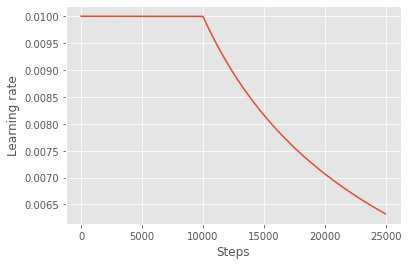

In [ ]:
plt.style.use('ggplot')
schedule = CustomSchedule()
plt.plot(schedule(tf.range(25000, dtype=tf.float32)))
plt.xlabel("Steps")
plt.ylabel("Learning rate")

In [ ]:
# learning_rate = CustomSchedule()
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# model = SnapthatT5.from_pretrained(save_path)
model = SnapthatT5.from_pretrained("t5-base")
# config = T5Config.from_json_file("/home/ml/workspace/ai/language-modelling/data/experiments/t5/models/config.json")
# model = SnapthatT5(config)


You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.compile(optimizer=optimizer, metrics=metrics)

In [ ]:
# model.save_pretrained(save_path)
# model.load_weights(checkpoint_filepath)

In [ ]:
epochs_done = 0
model.fit(train_ds, epochs=50, steps_per_epoch=steps, callbacks=callbacks, 
          validation_data=valid_ds, validation_steps=valid_steps, initial_epoch=epochs_done)

Epoch 1/50


/home/ml/anaconda3/envs/hugging/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ml/anaconda3/envs/hugging/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1768: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


 4305/21900 [====>.........................] - ETA: 2:07:09 - accuracy: 0.9583 - loss: 0.3908 - lr: 0.0010

KeyboardInterrupt: 

In [ ]:
# model.evaluate(valid_ds, steps=valid_steps)

In [ ]:
model.save_pretrained("/root/language-modelling/data/experiments/t5/models/T5-0022-0.2429")


In [ ]:
encoded_query = tokenizer("summarize: object detection </s>", 
                         return_tensors='tf', padding=True, truncation=True)
input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]
generated_question = model.generate(input_ids, attention_mask=attention_mask)
decoded_question = tokenizer.decode(generated_question.numpy()[0])

In [ ]:
decoded_question

'object detection is object detection?'

In [ ]:
no_questions = 5
encoded_query = tokenizer("ask_question: beards </s>", 
                         return_tensors='tf', truncation=True, 
                          pad_to_max_length=max_len)
input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]
generated_question = model.generate(input_ids, attention_mask=attention_mask,
                                   do_sample=True, max_length=max_len, top_p=0.98, top_k=50,
                                   num_return_sequences=no_questions, repetition_penalty=5)

In [ ]:
for en_question in list(generated_question):
    decoded_question = tokenizer.decode(en_question.numpy())
    print(decoded_question)

What is the other important way that humans are asked to be placed in a concert?
When was the first one of which other signs criticized by beers forbiding indentenent and mistruth?
How many ducks spawned for the first time?
When are the reds introduced?
What type of animal has been raised by a male group in The A-R?
